In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor, print_model_size

In [2]:
# Squeeze-and-Excitation block.
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduction):
        super().__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Output shape: (B, C, 1, 1)
            nn.Flatten(),             # Output shape: (B, C)
            nn.Linear(in_channels, in_channels // reduction, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.shape
        se_weight = self.se(x).view(b, c, 1, 1)
        return x * se_weight

# Mobile Inverted Bottleneck Convolution Block (MBConv).
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio=6, stride=1, se_ratio=0.25):
        super().__init__()
        hidden_channels = in_channels * expand_ratio
        self.use_residual = (stride == 1 and in_channels == out_channels)
        
        layers = []
        # Expansion phase: 1x1 conv (skip if expand_ratio == 1).
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_channels, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_channels))
            layers.append(nn.ReLU(inplace=True))
        else:
            hidden_channels = in_channels

        # Depthwise convolution.
        layers.append(nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, stride=stride, 
                                padding=1, groups=hidden_channels, bias=False))
        layers.append(nn.BatchNorm2d(hidden_channels))
        layers.append(nn.ReLU(inplace=True))
        
        # Squeeze-and-Excitation.
        if se_ratio is not None and se_ratio > 0:
            reduction = max(1, int(1/se_ratio))
            layers.append(SqueezeExcitation(hidden_channels, reduction))
        
        # Projection phase: 1x1 conv.
        layers.append(nn.Conv2d(hidden_channels, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        if self.use_residual:
            return x + self.block(x)
        else:
            return self.block(x)

# Simplified EfficientNet for CIFAR-10
class EfficientNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Stem: initial convolution.
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # MBConv blocks.
            # Block 1: No expansion (expand_ratio=1), stride=1.
            MBConvBlock(32, 16, expand_ratio=1, stride=1, se_ratio=0.25),
            # Block 2: Expand channels; downsample with stride=2.
            MBConvBlock(16, 24, expand_ratio=6, stride=2, se_ratio=0.25),
            MBConvBlock(24, 24, expand_ratio=6, stride=1, se_ratio=0.25),
            # Block 3: Downsample and increase channels.
            MBConvBlock(24, 40, expand_ratio=6, stride=2, se_ratio=0.25),
            MBConvBlock(40, 40, expand_ratio=6, stride=1, se_ratio=0.25),
            # Head: final 1x1 conv.
            nn.Conv2d(40, 1280, kernel_size=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True),
            # Global pooling and classifier.
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

In [3]:
print_model_size(EfficientNet())

Total params = 1.714060e+05
Trainable params = 1.714060e+05


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

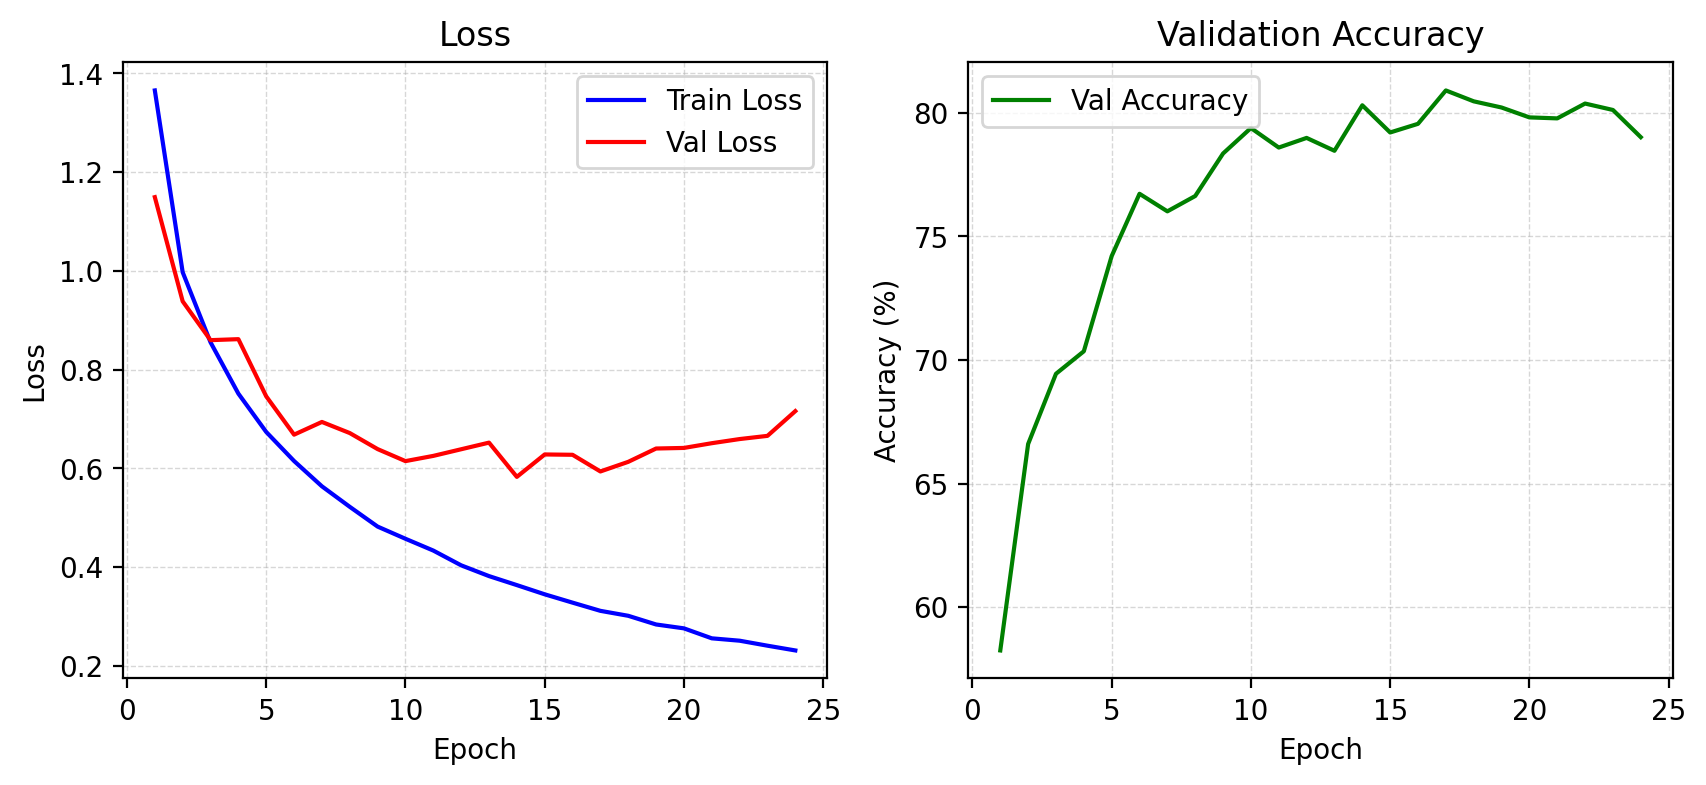

Epoch 24/30:  80%|########  | 24/30 [07:00<01:29, 14.90s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.3653       |       1.1492       |         58.2500         |
|         2          |       0.9971       |       0.9382       |         66.6000         |
|         3          |       0.8552       |       0.8596       |         69.4400         |
|         4          |       0.7513       |       0.8616       |         70.3500         |
|         5          |       0.6736       |       0.7458       |         74.2000         |
|         6          |       0.6148       |       0.6682       |         76.7200         |
|         7          |       0.5636       |       0.6939       |         76.0100         |
|         8          |       0.5220       |       0.6714       |         76.6300         |
|         9          |       0.4820       |       0.6389       |         78.3500         |

In [4]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)
